# Cuadrados mínimos lineal

In [1]:
%matplotlib notebook

In [2]:
import math
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [3]:
def get_ellipse(center, cova, nsigma=1):
    L = np.linalg.cholesky(cova)
    t = np.linspace(0, 2 * np.pi, 1000)
    circulo = np.column_stack([np.cos(t), np.sin(t)])
    elipse =  nsigma * circulo @ L.T + center
    return elipse.T

## Datos

In [4]:
xdata = np.array([1.0, 2.5, 3.1, 4, 5.5])
ydata = np.array([1.85, 2.72, 5.15, 5.7, 6.9])
ysigma = np.array([0.5, 0.5, 0.5, 0.5, 0.5])

In [5]:
ndatos = len(xdata)
ndatos

5

## Modelo

In [6]:
def modelo(x, y0, m):
    return y0 + m * x

## Función de costo

In [7]:
def funcion_costo(theta, xdata, ydata, ysigma):
        y0 = theta[0]
        m = theta[1]
        costo = np.zeros_like(y0)
        for (x1, y1, sigma1) in zip(xdata, ydata, ysigma):
            mu1 = modelo(x1, y0, m)
            residuo = y1 - mu1
            z = residuo / sigma1
            costo += z*z
        return costo

In [8]:
J = lambda theta: funcion_costo(theta, xdata, ydata, ysigma)  

In [9]:
y0 = np.linspace(-0.5, 1.5, 128)
m = np.linspace(0.8, 1.6, 128)
y0, m = np.meshgrid(y0, m)
theta = np.array([y0,m])
z = J(theta)

<IPython.core.display.Javascript object>


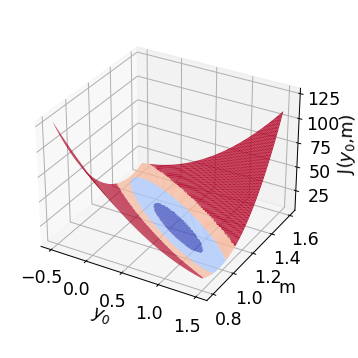

In [10]:
fig1 = plt.figure(figsize=(4,4))
ax1 = fig1.subplots(subplot_kw={"projection": "3d"})
ax1.set_xlabel('$y_0$')
ax1.set_ylabel('m')
ax1.set_zlabel('J($y_0$,m)')
bounds = z.min() + np.array([0, 1, 4, 9, 16]) 
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
ax1.plot_surface(y0, m, z, cmap=cm.coolwarm, norm=norm, rstride=1, cstride=1, linewidth=0)

In [ ]:
fig1.savefig('cml_costo.svg')

## Estimador de máxima verosimilitud

In [ ]:
V = np.diag(ysigma*ysigma)
V

In [ ]:
A = np.column_stack([np.ones(ndatos), xdata])
A

In [ ]:
cova = inv( A.T @ inv(V) @ A )
cova

In [ ]:
B = cova @ A.T @ inv(V)
B

In [ ]:
theta_est = B @ ydata
y0_est = theta_est[0]
m_est = theta_est[1]
theta_est

In [ ]:
dy0 = math.sqrt(cova[0][0])
dm = math.sqrt(cova[1][1])
rho = cova[0][1] / (dy0 *dm)

In [ ]:
print(f'Ordenada al origen:  {y0_est:2.2f} ± {dy0:2.2f}')
print(f'Pendiente ajustada: {m_est:2.2f} ± {dm:2.2f}')
print(f'Correlación: {rho:2.2f}')

## Plot del ajuste

In [ ]:
fig2, ax2 = plt.subplots()
ax2.set_xlabel('x')
ax2.set_ylabel('y')

Datos

In [ ]:
ax2.errorbar(xdata, ydata, ysigma,ls='none', marker='o', label='datos')

Ajuste

In [ ]:
x = np.linspace( xdata.min(), xdata.max(), 256)
mu_est = modelo(x, y0_est, m_est) 

In [ ]:
ax2.plot(x, mu_est, ls='--', label='ajuste')

In [ ]:
ax2.legend()

## Región de confianza de los parámetros

In [ ]:
fig3, ax3 = plt.subplots()
ax3.set_xlabel('y0')
ax3.set_ylabel('m')

In [ ]:
elipse_1sigma = get_ellipse(theta_est, cova, nsigma=1)
ax3.plot(*elipse_1sigma, ls='--')
elipse_2sigma = get_ellipse(theta_est, cova, nsigma=2)
ax3.plot(*elipse_2sigma, ls='--')
elipse_3sigma = get_ellipse(theta_est, cova, nsigma=3)
ax3.plot(*elipse_3sigma, ls='--')
ax3.plot(*theta_est, 'o')

In [ ]:
fig3.savefig('cml_parametros.svg')

## Banda de error

In [ ]:
fig4, ax4 = plt.subplots()
ax4.set_xlabel('x')
ax4.set_ylabel('$\sigma_\hat{\mu}$')

In [ ]:
var_mu_est = cova[0][0] + x**2*cova[1][1] + 2*x*cova[0][1]
sigma_mu_est = np.sqrt(var_mu_est)

In [ ]:
ax4.plot(x, sigma_mu_est)

In [ ]:
ax2.fill_between(x, mu_est-sigma_mu_est, mu_est+sigma_mu_est, color='tab:orange', alpha=0.2)

In [ ]:
fig2.savefig('cml_ajuste.svg')

## Bondad del ajuste

In [ ]:
C = ydata - A @ theta_est
J_min_observado = C.T @ inv(V) @ C
J_min_observado

In [ ]:
grados_libertad = ndatos - 2
grados_libertad

In [ ]:
pvalor = chi2.sf(J_min_observado, grados_libertad)
print(f'pvalor = {pvalor*100:.2f}%')

## Ajuste con scipy.optimize.curve_fit

In [ ]:
popt, pcov = curve_fit(modelo, xdata, ydata, sigma=ysigma, absolute_sigma=True)

In [ ]:
print("Parametros ajustados: ", popt)

In [ ]:
print("Covarianza estimada: ", pcov)

No reporta el chi-cuadrado del ajuste directamente, se debe calcular como en el ajuste manual :(

In [ ]:
J_min = J(popt)
J_min

## Ajuste con scipy.optimize.minimize

In [ ]:
res = minimize(J, x0=(0,0))
res

In [ ]:
print("Parametros ajustados: ", res.x)

Se necesita un factor 2 en la matriz de covarianza porque minimimize asume J = -ln(L), nosotros usamos J = -2*ln(L)

In [ ]:
cova = 2*res.hess_inv
print("Covarianza estimada: ", cova) 

In [ ]:
par_error = np.sqrt( np.diagonal(cova) )
print("Errores de los parámetros", par_error)

In [ ]:
print("Chi2 mínimo: ", res.fun)